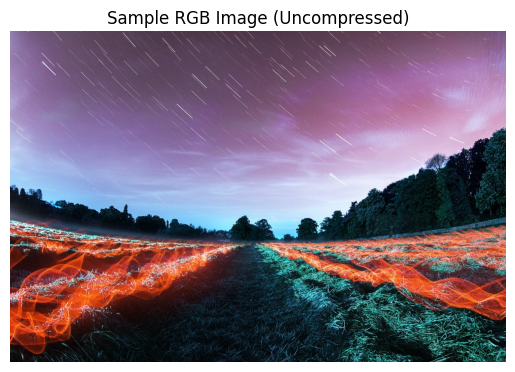

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
from skimage import color
import os
import cv2
import heapq
from collections import defaultdict
import heapq
from collections import defaultdict, Counter

raw_img_path = os.path.join(os.getcwd(), 'data', 'raw_img.tiff')

img = cv2.imread(raw_img_path, cv2.IMREAD_UNCHANGED)

plt.imshow(img)
plt.title('Sample RGB Image (Uncompressed)')
plt.axis('off')
plt.show()

## Step 1: Convert to YCbCr color space

In [2]:
def rgb_to_ycbcr(img_rgb):
    """
    Convert an RGB image to YCbCr color space.
    """
    img_ycbcr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2YCrCb)
    return img_ycbcr

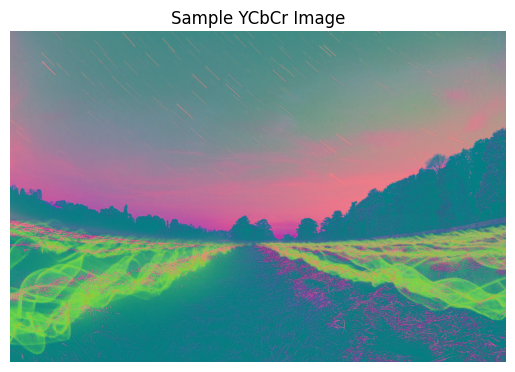

In [3]:
img_ycbcr = rgb_to_ycbcr(img)

plt.imshow(img_ycbcr)
plt.title('Sample YCbCr Image')
plt.axis('off')
plt.show()

---
## Step 2: Chrominance downsampling

In [4]:
def chrominance_downsampling(img_ycbcr):
    """
    Downsample the chrominance channels (Cb, Cr) by a factor of 2 (4:2:0).
    """
    # Extract Y, Cb, and Cr channels
    Y, Cb, Cr = cv2.split(img_ycbcr)

    # Downsample Cb and Cr channels by 2 (4:2:0 sampling)
    Cb_downsampled = cv2.resize(Cb, (Cb.shape[1] // 2, Cb.shape[0] // 2), interpolation=cv2.INTER_LINEAR)
    Cr_downsampled = cv2.resize(Cr, (Cr.shape[1] // 2, Cr.shape[0] // 2), interpolation=cv2.INTER_LINEAR)

    return Y, Cb_downsampled, Cr_downsampled

In [5]:
img_y, img_cb, img_cr = chrominance_downsampling(img_ycbcr)
print(f"Shape of Y channel: {img_y.shape} | Shape of Cb channel: {img_cb.shape} | Shape of Cr channel: {img_cr.shape}")

Shape of Y channel: (853, 1280) | Shape of Cb channel: (426, 640) | Shape of Cr channel: (426, 640)


#### Additional Step 2: Chrominance upsampling

In [6]:
def upsample_and_merge(Y, Cb_downsampled, Cr_downsampled):
    """
    Upsample the Cb and Cr channels back to the original Y channel size 
    and merge them into a single YCbCr image.
    """
    # Upsample Cb and Cr channels back to original Y channel size
    Cb_upsampled = cv2.resize(Cb_downsampled, (Y.shape[1], Y.shape[0]), interpolation=cv2.INTER_LINEAR)
    Cr_upsampled = cv2.resize(Cr_downsampled, (Y.shape[1], Y.shape[0]), interpolation=cv2.INTER_LINEAR)

    # Merge Y, Cb, and Cr back into a single YCbCr image
    img_ycbcr_upsampled = cv2.merge([Y, Cb_upsampled, Cr_upsampled])
    return img_ycbcr_upsampled

Shape of processed YCbCr image: (853, 1280, 3)


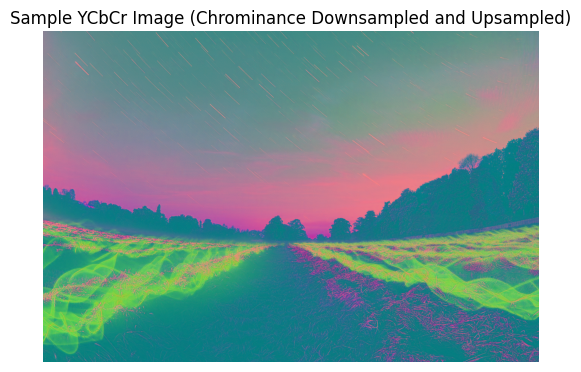

In [7]:
img_ycbcr_processed = upsample_and_merge(img_y, img_cb, img_cr)
print(f"Shape of processed YCbCr image: {img_ycbcr_processed.shape}")

plt.imshow(img_ycbcr_processed)
plt.title('Sample YCbCr Image (Chrominance Downsampled and Upsampled)')
plt.axis('off')
plt.show()

---
## Step 3: Discrete cosine transform (DCT)

In [8]:
def apply_dct(block):
    """
    Apply Discrete Cosine Transform (DCT) to an 8x8 block.
    """
    return dct(dct(block.T, norm='ortho').T, norm='ortho')
    
def dct_on_blocks(img_channel):
    """
    Divide the image channel into 8x8 blocks and apply DCT to each block.
    """
    h, w = img_channel.shape
    dct_transformed = np.zeros((h, w))

    # Process each 8x8 block
    for i in range(0, h, 8):
        for j in range(0, w, 8):
            block = img_channel[i:i+8, j:j+8]
            dct_transformed[i:i+8, j:j+8] = apply_dct(block)

    return dct_transformed

In [9]:
# Assuming img_ycbcr_upsampled is the output from the previous upsample_and_merge step
Y, Cb, Cr = cv2.split(img_ycbcr_processed)

# Apply DCT to each channel
Y_dct = dct_on_blocks(Y)
Cb_dct = dct_on_blocks(Cb)
Cr_dct = dct_on_blocks(Cr)

print(f"Shape of Y channel after DCT: {Y_dct.shape} | Shape of Cb channel after DCT: {Cb_dct.shape} | Shape of Cr channel after DCT: {Cr_dct.shape}")

Shape of Y channel after DCT: (853, 1280) | Shape of Cb channel after DCT: (853, 1280) | Shape of Cr channel after DCT: (853, 1280)


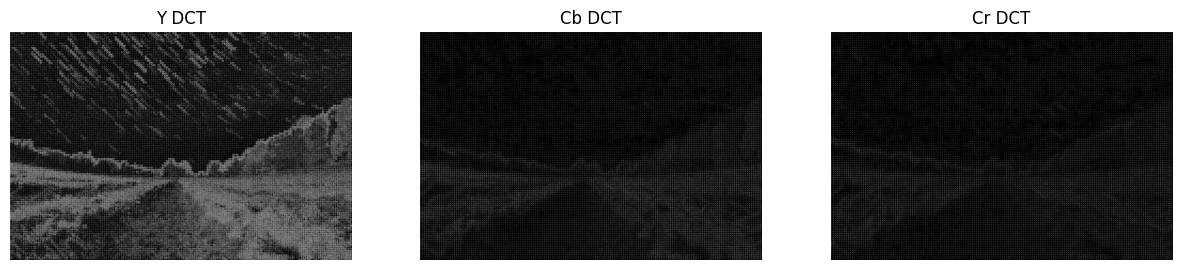

In [10]:
y_dct_norm = np.log(np.abs(Y_dct) + 1)
cb_dct_norm = np.log(np.abs(Cb_dct) + 1)
cr_dct_norm = np.log(np.abs(Cr_dct) + 1)

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
ax[0].imshow(y_dct_norm, cmap = 'gray')
ax[0].set_title('Y DCT')
ax[0].axis('off')
ax[1].imshow(cb_dct_norm, cmap = 'gray')
ax[1].set_title('Cb DCT')
ax[1].axis('off')
ax[2].imshow(cr_dct_norm, cmap = 'gray')
ax[2].set_title('Cr DCT')
ax[2].axis('off')
plt.show()

---
## Step 4: Quantization


In [11]:
# Standard JPEG quantization tables
LUMINANCE_QUANT_TABLE = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

CHROMINANCE_QUANT_TABLE = np.array([
    [17, 18, 24, 47, 99, 99, 99, 99],
    [18, 21, 26, 66, 99, 99, 99, 99],
    [24, 26, 56, 99, 99, 99, 99, 99],
    [47, 66, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99]
])

def pad_image(image, block_size=8):
    """
    Pad the image so its dimensions are divisible by the block size (8x8 for JPEG).
    """
    h, w = image.shape[:2]
    padded_h = h if h % block_size == 0 else h + block_size - h % block_size
    padded_w = w if w % block_size == 0 else w + block_size - w % block_size

    # Apply padding to the image
    padded_image = np.zeros((padded_h, padded_w), dtype=image.dtype)
    padded_image[:h, :w] = image

    return padded_image

def quantize_block(block, quant_table):
    """
    Quantize an 8x8 block using the specified quantization table.
    """
    return np.round(block / quant_table)

def quantize_image(img_dct, is_luminance=True):
    """
    Apply quantization to the entire image, separating it into 8x8 blocks.
    Use the luminance quantization table for the Y channel, and chrominance for Cb and Cr.
    """
    quant_table = LUMINANCE_QUANT_TABLE if is_luminance else CHROMINANCE_QUANT_TABLE
    h, w = img_dct.shape
    quantized_img = np.zeros((h, w))

    # Process each 8x8 block
    for i in range(0, h, 8):
        for j in range(0, w, 8):
            block = img_dct[i:i+8, j:j+8]
            quantized_img[i:i+8, j:j+8] = quantize_block(block, quant_table)

    return quantized_img

In [12]:
# Ensure Y, Cb, and Cr are padded to 8x8 blocks
Y_padded = pad_image(Y_dct)
Cb_padded = pad_image(Cb_dct)
Cr_padded = pad_image(Cr_dct)

# Apply quantization to each channel
Y_quantized = quantize_image(Y_padded, is_luminance=True)
Cb_quantized = quantize_image(Cb_padded, is_luminance=False)
Cr_quantized = quantize_image(Cr_padded, is_luminance=False)

Preview

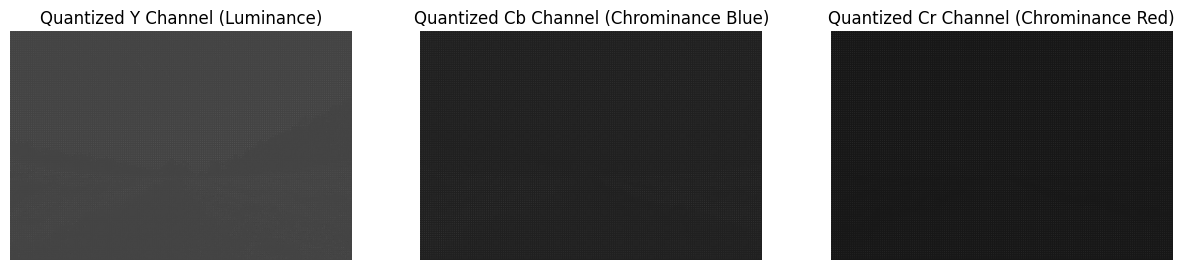

In [13]:
# Since quantized values might be large or negative, we'll normalize them for visualization
def normalize_quantized_channel(channel):
    return (channel - np.min(channel)) / (np.max(channel) - np.min(channel))

# Normalize each quantized channel for visualization
Y_quantized_normalized = normalize_quantized_channel(Y_quantized)
Cb_quantized_normalized = normalize_quantized_channel(Cb_quantized)
Cr_quantized_normalized = normalize_quantized_channel(Cr_quantized)

# Display the normalized quantized Y, Cb, and Cr channels
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(Y_quantized_normalized, cmap='gray')
ax[0].set_title('Quantized Y Channel (Luminance)')
ax[0].axis('off')

ax[1].imshow(Cb_quantized_normalized, cmap='gray')
ax[1].set_title('Quantized Cb Channel (Chrominance Blue)')
ax[1].axis('off')

ax[2].imshow(Cr_quantized_normalized, cmap='gray')
ax[2].set_title('Quantized Cr Channel (Chrominance Red)')
ax[2].axis('off')

plt.show()

---
## Step 5: Zigzag scan

In [14]:
ZIGZAG_ORDER = np.array([
    [0,  1,  5,  6, 14, 15, 27, 28],
    [2,  4,  7, 13, 16, 26, 29, 42],
    [3,  8, 12, 17, 25, 30, 41, 43],
    [9, 11, 18, 24, 31, 40, 44, 53],
    [10, 19, 23, 32, 39, 45, 52, 54],
    [20, 22, 33, 38, 46, 51, 55, 60],
    [21, 34, 37, 47, 50, 56, 59, 61],
    [35, 36, 48, 49, 57, 58, 62, 63]
])

def zigzag_scan(block):
    """
    Perform zig-zag scan on an 8x8 block.
    """
    return block.flatten()[ZIGZAG_ORDER.flatten()]

def apply_zigzag_to_image(img_quantized):
    """
    Apply zig-zag scan to each 8x8 block in the quantized image.
    """
    h, w = img_quantized.shape
    zigzag_scanned = []

    # Process each 8x8 block
    for i in range(0, h, 8):
        for j in range(0, w, 8):
            block = img_quantized[i:i+8, j:j+8]
            zigzag_scanned.append(zigzag_scan(block))

    return np.array(zigzag_scanned)

In [15]:
# Apply zig-zag scan to Y, Cb, and Cr channels
Y_zigzag = apply_zigzag_to_image(Y_quantized)
Cb_zigzag = apply_zigzag_to_image(Cb_quantized)
Cr_zigzag = apply_zigzag_to_image(Cr_quantized)

print(f"Shape of Y channel after zig-zag scan: {Y_zigzag.shape} | Shape of Cb channel after zig-zag scan: {Cb_zigzag.shape} | Shape of Cr channel after zig-zag scan: {Cr_zigzag.shape}")

Shape of Y channel after zig-zag scan: (17120, 64) | Shape of Cb channel after zig-zag scan: (17120, 64) | Shape of Cr channel after zig-zag scan: (17120, 64)


---
## Step 6: Run-length encoding

In [16]:
def run_length_encoding(block):
    """
    Perform Run-Length Encoding (RLE) on a zig-zag scanned 1D block.
    """
    rle = []
    zeros_count = 0
    
    for i, val in enumerate(block):
        if val == 0:
            zeros_count += 1
        else:
            # Record the (zeros_count, non-zero value) pair
            rle.append((zeros_count, val))
            zeros_count = 0
    
    # End with (0, 0) to signal end of block
    rle.append((0, 0))
    
    return rle

def apply_rle_to_image(zigzag_scanned):
    """
    Apply Run-Length Encoding (RLE) to all zig-zag scanned blocks of the image.
    """
    rle_encoded = []
    
    # Apply RLE to each zig-zag scanned block
    for block in zigzag_scanned:
        rle_encoded.append(run_length_encoding(block))
    
    return rle_encoded

In [17]:
# Apply RLE to each zig-zag scanned channel
Y_rle = apply_rle_to_image(Y_zigzag)
Cb_rle = apply_rle_to_image(Cb_zigzag)
Cr_rle = apply_rle_to_image(Cr_zigzag)

print(f"Shape of Y channel after RLE: {len(Y_rle)} | Shape of Cb channel after RLE: {len(Cb_rle)} | Shape of Cr channel after RLE: {len(Cr_rle)}")

Shape of Y channel after RLE: 17120 | Shape of Cb channel after RLE: 17120 | Shape of Cr channel after RLE: 17120


---
## Step 7: Huffman encoding

In [18]:
class HuffmanNode:
    def __init__(self, symbol, freq):
        self.symbol = symbol
        self.freq = freq
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.freq < other.freq

def build_huffman_tree(frequency):
    """
    Build a Huffman tree based on symbol frequencies.
    """
    heap = [HuffmanNode(symbol, freq) for symbol, freq in frequency.items()]
    heapq.heapify(heap)

    while len(heap) > 1:
        node1 = heapq.heappop(heap)
        node2 = heapq.heappop(heap)
        merged = HuffmanNode(None, node1.freq + node2.freq)
        merged.left = node1
        merged.right = node2
        heapq.heappush(heap, merged)

    return heap[0]

def build_huffman_codes(node, prefix="", huffman_codes={}):
    """
    Recursively build Huffman codes from the Huffman tree.
    """
    if node is None:
        return

    if node.symbol is not None:
        huffman_codes[node.symbol] = prefix

    build_huffman_codes(node.left, prefix + "0", huffman_codes)
    build_huffman_codes(node.right, prefix + "1", huffman_codes)

    return huffman_codes

def huffman_encoding(rle_data):
    """
    Perform Huffman encoding on RLE data.
    """
    # Flatten the RLE data to extract all symbols
    flattened_rle = [item for block in rle_data for item in block]

    # Count the frequency of each symbol
    frequency = Counter(flattened_rle)

    # Build the Huffman tree
    huffman_tree = build_huffman_tree(frequency)

    # Generate Huffman codes
    huffman_codes = build_huffman_codes(huffman_tree)

    # Encode the RLE data using Huffman codes
    encoded_data = []
    for block in rle_data:
        encoded_block = ''.join([huffman_codes[item] for item in block])
        encoded_data.append(encoded_block)

    return encoded_data, huffman_codes

In [19]:
# Apply Huffman encoding to Y, Cb, and Cr channels
Y_huffman, Y_huffman_codes = huffman_encoding(Y_rle)
Cb_huffman, Cb_huffman_codes = huffman_encoding(Cb_rle)
Cr_huffman, Cr_huffman_codes = huffman_encoding(Cr_rle)

print(f"Shape of Y channel after Huffman encoding: {len(Y_huffman)} | Shape of Cb channel after Huffman encoding: {len(Cb_huffman)} | Shape of Cr channel after Huffman encoding: {len(Cr_huffman)}")
print(f"Shape of Y Huffman codes: {len(Y_huffman_codes)} | Shape of Cb Huffman codes: {len(Cb_huffman_codes)} | Shape of Cr Huffman codes: {len(Cr_huffman_codes)}")

Shape of Y channel after Huffman encoding: 17120 | Shape of Cb channel after Huffman encoding: 17120 | Shape of Cr channel after Huffman encoding: 17120
Shape of Y Huffman codes: 608 | Shape of Cb Huffman codes: 608 | Shape of Cr Huffman codes: 608


---
## Step 8: Decoding

In [20]:
def huffman_decoding(encoded_data, huffman_codes):
    """
    Decode Huffman encoded data back into RLE data.
    """
    # Invert the Huffman codes to get code-to-symbol mapping
    code_to_symbol = {v: k for k, v in huffman_codes.items()}
    decoded_data = []

    for encoded_block in encoded_data:
        current_code = ''
        decoded_block = []
        for bit in encoded_block:
            current_code += bit
            if current_code in code_to_symbol:
                symbol = code_to_symbol[current_code]
                decoded_block.append(symbol)
                current_code = ''
        decoded_data.append(decoded_block)

    return decoded_data

def inverse_run_length_encoding(rle_block):
    """
    Reconstruct the zig-zag scanned block from RLE data.
    """
    block = []
    for zeros_count, value in rle_block:
        block.extend([0] * zeros_count)
        if (zeros_count, value) != (0, 0):  # End of Block marker
            block.append(value)
        else:
            break
    # Pad with zeros if the block is incomplete
    block.extend([0] * (64 - len(block)))
    return np.array(block)

def inverse_zigzag_scan(block):
    """
    Reconstruct an 8x8 block from a zig-zag scanned 1D array.
    """
    block_2d = np.zeros((8, 8))
    index_order = np.argsort(ZIGZAG_ORDER, axis=None)
    block_2d.flat[index_order] = block
    return block_2d

def dequantize_block(quantized_block, quant_table):
    """
    Dequantize an 8x8 block by multiplying with the quantization table.
    """
    return quantized_block * quant_table

def dequantize_image(quantized_blocks, quant_table):
    """
    Dequantize all blocks in the image.
    """
    return [dequantize_block(block, quant_table) for block in quantized_blocks]

def apply_idct(block):
    """
    Apply Inverse Discrete Cosine Transform (IDCT) to an 8x8 block.
    """
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

def reconstruct_image_from_blocks(blocks, height, width):
    """
    Reconstruct the image channel from 8x8 blocks, with padding management.
    Handles edge cases where image dimensions are not divisible by 8.
    """
    reconstructed = np.zeros((height, width))
    idx = 0
    block_h, block_w = 8, 8
    
    for i in range(0, height, block_h):
        for j in range(0, width, block_w):
            block = blocks[idx]
            actual_block_h = min(block_h, height - i)
            actual_block_w = min(block_w, width - j)
            reconstructed[i:i+actual_block_h, j:j+actual_block_w] = block[:actual_block_h, :actual_block_w]
            idx += 1
    return reconstructed

def ycbcr_to_rgb(img_ycbcr):
    """
    Convert a YCbCr image back to RGB color space.
    """
    img_rgb = cv2.cvtColor(img_ycbcr.astype(np.uint8), cv2.COLOR_YCrCb2RGB)
    return img_rgb

def decompress_image(encoded_data, huffman_codes, quant_table, height, width):
    """
    Decompress a single image channel from Huffman encoded data.
    """
    # Huffman decoding
    decoded_rle = huffman_decoding(encoded_data, huffman_codes)
    # Inverse RLE
    rle_blocks = [inverse_run_length_encoding(block) for block in decoded_rle]
    # Inverse Zig-Zag scan
    zigzag_blocks = [inverse_zigzag_scan(block) for block in rle_blocks]
    # Dequantization
    dequantized_blocks = dequantize_image(zigzag_blocks, quant_table)
    # Inverse DCT
    idct_blocks = [apply_idct(block) for block in dequantized_blocks]
    # Reconstruct the image channel
    channel = reconstruct_image_from_blocks(idct_blocks, height, width)
    channel = np.clip(channel, 0, 255)
    return channel

def decompress_full_image(Y_encoded_data, Y_huffman_codes, Cb_encoded_data, Cb_huffman_codes,
                          Cr_encoded_data, Cr_huffman_codes, original_height, original_width):
    """
    Decompress the full image from Huffman encoded data for Y, Cb, and Cr channels.
    """
    # Quantization tables
    Y_quant_table = LUMINANCE_QUANT_TABLE
    C_quant_table = CHROMINANCE_QUANT_TABLE

    # Decompress Y channel
    Y_channel = decompress_image(Y_encoded_data, Y_huffman_codes, Y_quant_table, original_height, original_width)
    
    Cb_channel = decompress_image(Cb_encoded_data, Cb_huffman_codes, C_quant_table, original_height // 2, original_width // 2)
    Cb_channel = cv2.resize(Cb_channel, (original_width, original_height), interpolation=cv2.INTER_LINEAR)
    
    # Decompress and upsample Cr channel
    Cr_channel = decompress_image(Cr_encoded_data, Cr_huffman_codes, C_quant_table, original_height // 2, original_width // 2)
    Cr_channel = cv2.resize(Cr_channel, (original_width, original_height), interpolation=cv2.INTER_LINEAR)
    
    # Now ensure data types and clipping
    Y_channel = np.clip(Y_channel, 0, 255)
    Cb_channel = np.clip(Cb_channel, 0, 255)
    Cr_channel = np.clip(Cr_channel, 0, 255)
    
    
    
    
    # Merge channels and convert to RGB
    img_ycbcr = cv2.merge([Y_channel, Cb_channel, Cr_channel])
    img_ycbcr = np.clip(img_ycbcr, 0, 255).astype(np.uint8)
    img_rgb = cv2.cvtColor(img_ycbcr, cv2.COLOR_YCrCb2RGB)
    # img_rgb = ycbcr_to_rgb(img_ycbcr)
    return img_rgb.astype(np.uint8)

In [21]:
img_compressed = decompress_full_image(Y_huffman, Y_huffman_codes, Cb_huffman, Cb_huffman_codes, Cr_huffman, Cr_huffman_codes, img_y.shape[0], img_y.shape[1])

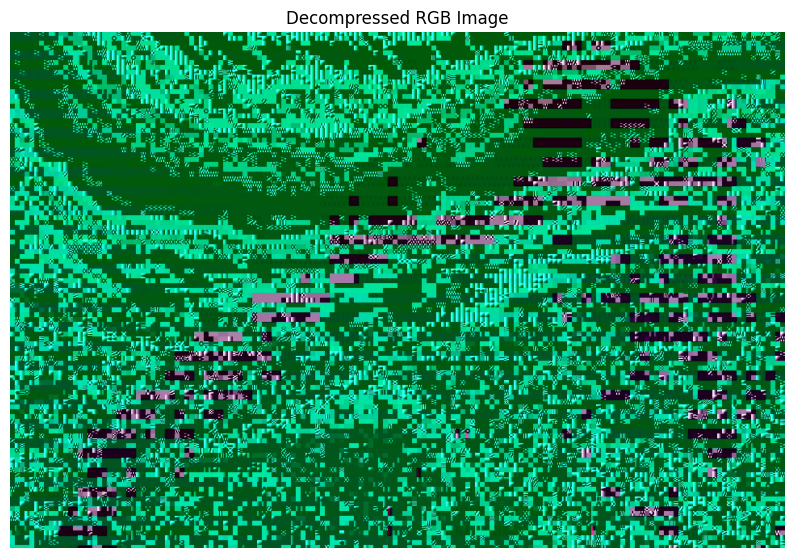

In [22]:
plt.figure(figsize=(10, 10))
plt.imshow(img_compressed)
plt.title('Decompressed RGB Image')
plt.axis('off')
plt.show()